#**Unsupervised Learning**

###**Neural Network - Restricted Boltzman Machines (RBM)**

RBM is used for dimensionality reduction, classification, regression, collaborative filtering, feature learning, and topic modelling.

(1797, 64)




<Figure size 640x480 with 0 Axes>

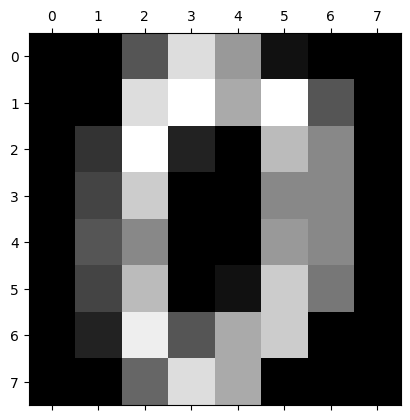

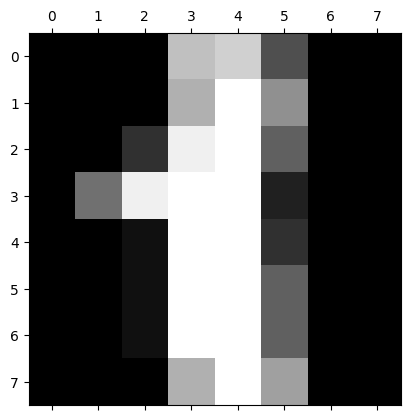

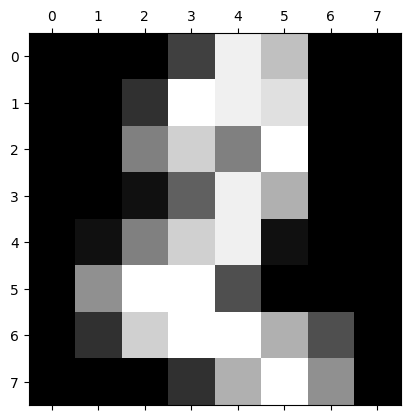

In [4]:
#Convert an array to an image
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
print("\n")

#Plot
#Display an array as a matrix in a new figure window.
plt.gray()
plt.matshow(digits.images[0])
plt.matshow(digits.images[1])
plt.matshow(digits.images[2])
# plt.matshow(digits.images[3])
# plt.matshow(digits.images[4])
# plt.matshow(digits.images[5])
plt.show()


(1797, 64)


The first array for X in a normalised form 
[0.         0.         0.31249806 0.812495   0.56249654 0.06249961
 0.         0.         0.         0.         0.812495   0.9374942
 0.6249961  0.9374942  0.31249806 0.         0.         0.18749884
 0.9374942  0.12499923 0.         0.68749577 0.4999969  0.
 0.         0.24999845 0.74999535 0.         0.         0.4999969
 0.4999969  0.         0.         0.31249806 0.4999969  0.
 0.         0.56249654 0.4999969  0.         0.         0.24999845
 0.68749577 0.         0.06249961 0.74999535 0.4374973  0.
 0.         0.12499923 0.8749946  0.31249806 0.6249961  0.74999535
 0.         0.         0.         0.         0.37499768 0.812495
 0.6249961  0.         0.         0.        ]


[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.13s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 0.26s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 0.25s
[BernoulliRBM] Iteration 4, pseudo-likelihood 

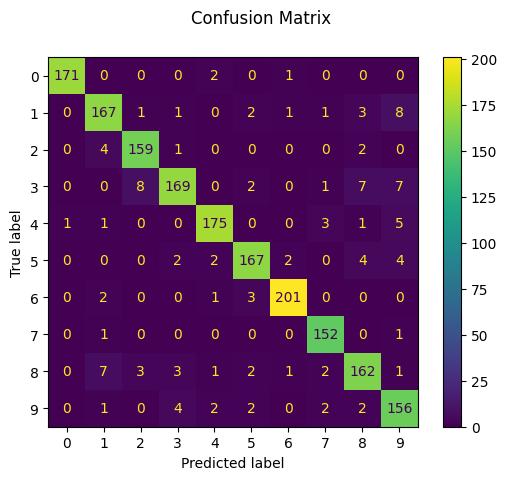

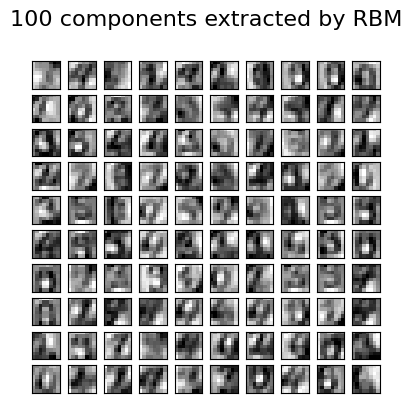

In [7]:
#https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.datasets import load_digits
from sklearn.metrics import ConfusionMatrixDisplay

#Load Dataset to view the shape of the dataset
digits = load_digits()
print(digits.data.shape)

# #############################################################################
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] + [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)

    return X, Y

#Load dataset and split into X and y
X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, 'float32')
X, Y = nudge_dataset(X, y)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling or in other words normalisation of data

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)
print("\n")
print("The first array for X in a normalised form ")
print(X[0])
print("\n")

# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)


#Use the model for prediction
new_input = [[0,0,5,13,9,1,0,0,0,0,13,15,10,15,5,0,0,3,15,2,0,11,8,0,0,4,12,0,0,8,8,0,0,5,8,0,0,9,8,0,0,4,11,0,1,12,7,0,0,2,14,5,10,12,0,0,0,0,6,13,10,0,0,0]]
new_y = rbm_features_classifier.predict(new_input)
print("\n")
print("The input is ", new_input)
print("The predicted digit is ", new_y)
print("\n")

# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

#Confusion Matrix
print("Classification report for classifier %s:\n%s\n"
      % (rbm_features_classifier, metrics.classification_report(Y_test, Y_pred)))
# disp = metrics.plot_confusion_matrix(rbm_features_classifier, X_test, Y_test)
disp = ConfusionMatrixDisplay.from_estimator(rbm_features_classifier, X_test, Y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)
print("\n")

plt.show()
print("\n")

# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()


###**Manifold Learning**

Manifold Learning can be thought of as an attempt to generalize linear frameworks like PCA to be sensitive to non-linear structure in data

Automatically created module for IPython interactive environment
Computing random projection
Computing PCA projection
Computing Linear Discriminant Analysis projection
Computing Isomap projection
Done.
Computing LLE embedding
Done. Reconstruction error: 8.99608e-07
Computing modified LLE embedding
Done. Reconstruction error: 0.36107
Computing Hessian LLE embedding
Done. Reconstruction error: 0.212908
Computing LTSA embedding
Done. Reconstruction error: 0.212893
Computing MDS embedding


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Done. Stress: 143069406.161738
Computing Totally Random Trees embedding
Computing Spectral embedding
Computing t-SNE embedding
Computing NCA projection


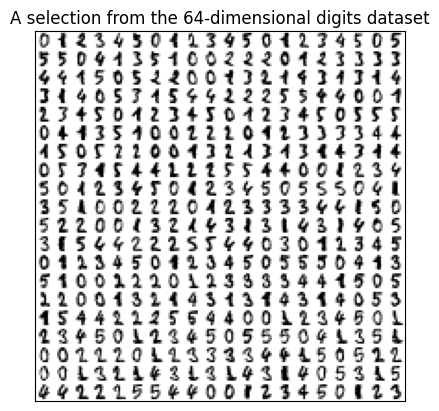

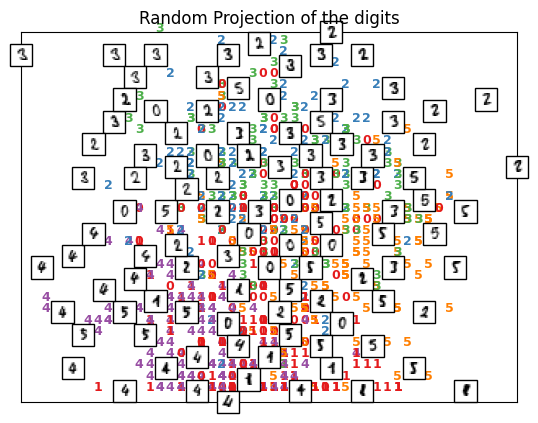

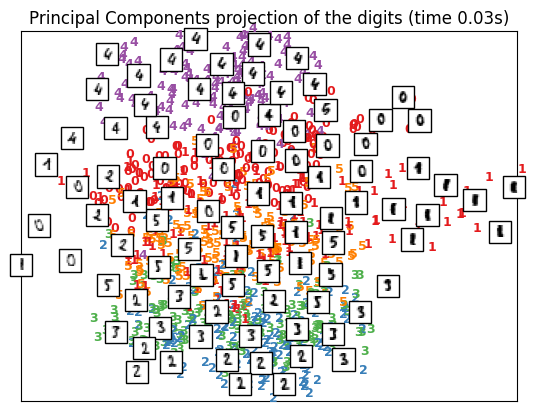

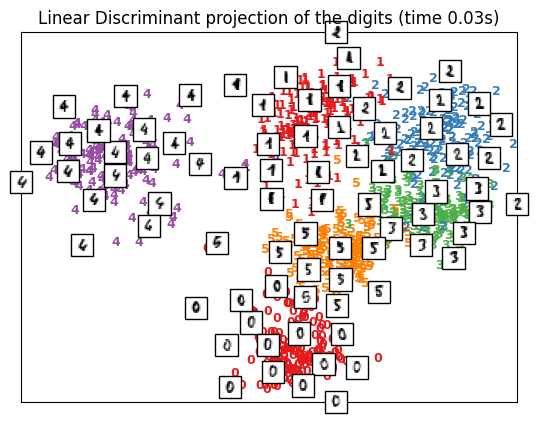

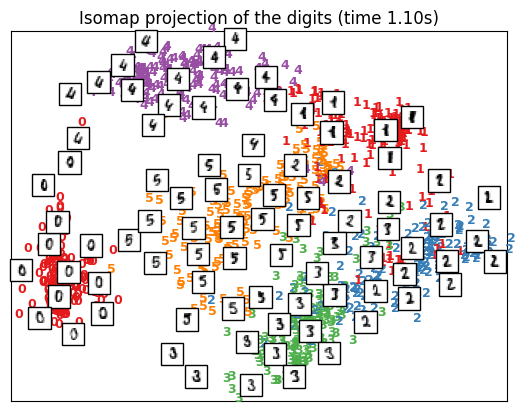

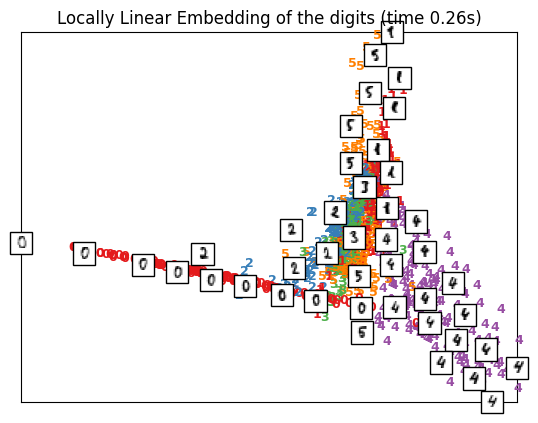

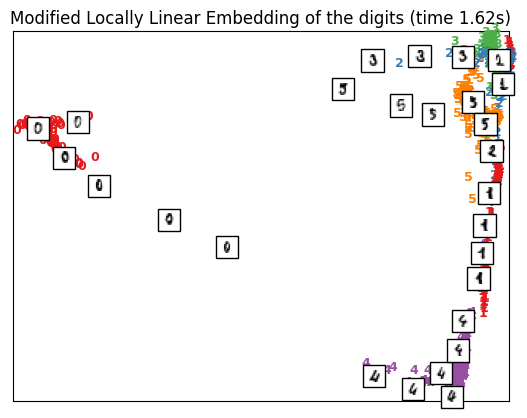

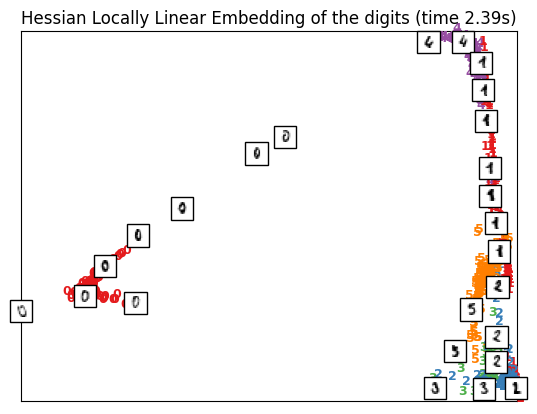

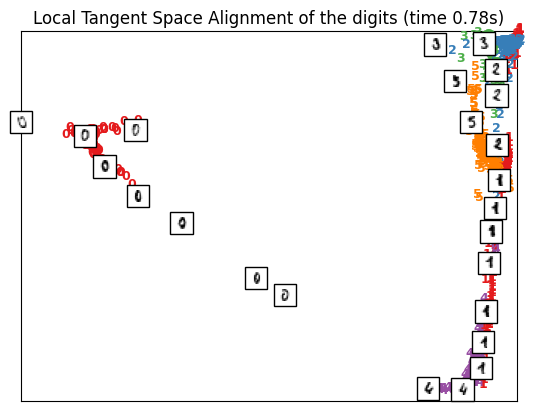

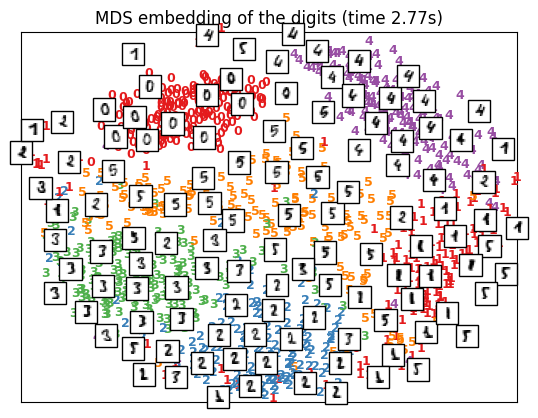

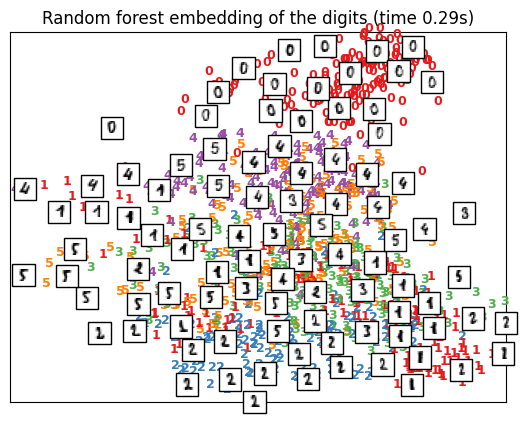

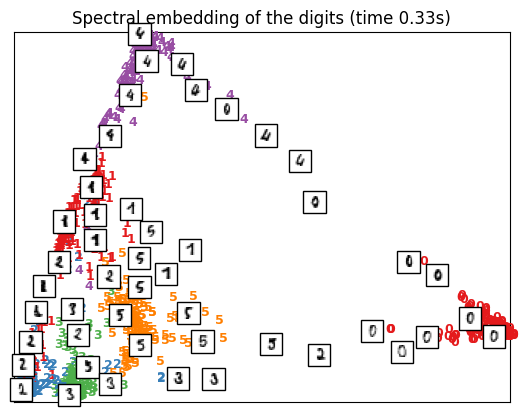

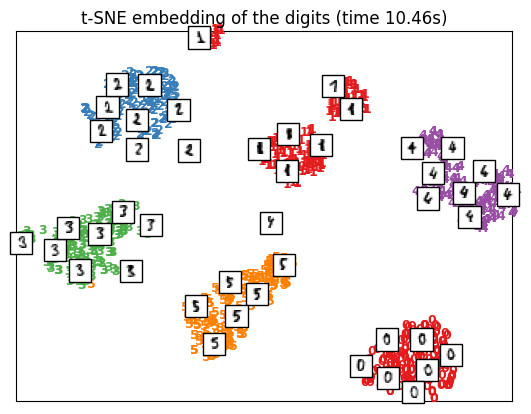

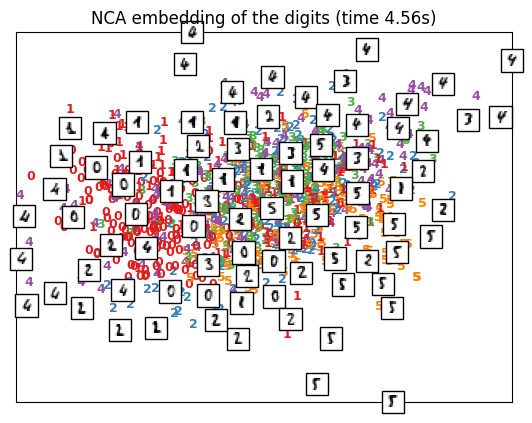

In [8]:
#Example 2.1 Manifold Learning of handwritten digits
#https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
print(__doc__)

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

# ----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


# ----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')


# ----------------------------------------------------------------------
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")


# ----------------------------------------------------------------------
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

# ----------------------------------------------------------------------
# Projection on to the first 2 linear discriminant components

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2
                                                         ).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))


# ----------------------------------------------------------------------
# Isomap projection of the digits dataset
print("Computing Isomap projection")
t0 = time()
X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2
                        ).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))


# ----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle,
               "Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))


# ----------------------------------------------------------------------
# Modified Locally linear embedding of the digits dataset
print("Computing modified LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle,
               "Modified Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))


# ----------------------------------------------------------------------
# HLLE embedding of the digits dataset
print("Computing Hessian LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='hessian')
t0 = time()
X_hlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_hlle,
               "Hessian Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))


# ----------------------------------------------------------------------
# LTSA embedding of the digits dataset
print("Computing LTSA embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='ltsa')
t0 = time()
X_ltsa = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_ltsa,
               "Local Tangent Space Alignment of the digits (time %.2fs)" %
               (time() - t0))

# ----------------------------------------------------------------------
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

# ----------------------------------------------------------------------
# Random Trees embedding of the digits dataset
print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
                                       max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced,
               "Random forest embedding of the digits (time %.2fs)" %
               (time() - t0))

# ----------------------------------------------------------------------
# Spectral embedding of the digits dataset
print("Computing Spectral embedding")
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)

plot_embedding(X_se,
               "Spectral embedding of the digits (time %.2fs)" %
               (time() - t0))

# ----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

# ----------------------------------------------------------------------
# NCA projection of the digits dataset
print("Computing NCA projection")
nca = neighbors.NeighborhoodComponentsAnalysis(init='random',
                                               n_components=2, random_state=0)
t0 = time()
X_nca = nca.fit_transform(X, y)

plot_embedding(X_nca,
               "NCA embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()


#**Supervised Learning**

###**K-Nearest Neighbour (KNN)**

K is the number of nearest neighbours

In [11]:
#KNN
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

from sklearn.neighbors import KNeighborsClassifier
#Data
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]

#Build and fit classififier
neigh = KNeighborsClassifier(n_neighbors=3)
model = neigh.fit(X, y)
print(model)

#Use model for prediction
print("Predicted classification is", neigh.predict([[1.1]]))
print("Predicted probabilities are", neigh.predict_proba([[0.9]]))
print("\n")


KNeighborsClassifier(n_neighbors=3)
Predicted classification is [0]
Predicted probabilities are [[0.66666667 0.33333333]]




              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.25      0.05      0.09        19
           5       0.67      0.71      0.69       190
           6       0.64      0.61      0.63       206
           7       0.50      0.70      0.58        53
           8       1.00      0.09      0.17        11

    accuracy                           0.62       480
   macro avg       0.51      0.36      0.36       480
weighted avg       0.63      0.62      0.61       480

[[  0   0   0   1   0   0]
 [  3   1   7   8   0   0]
 [  1   3 134  42  10   0]
 [  0   0  58 126  22   0]
 [  0   0   2  14  37   0]
 [  0   0   0   5   5   1]]




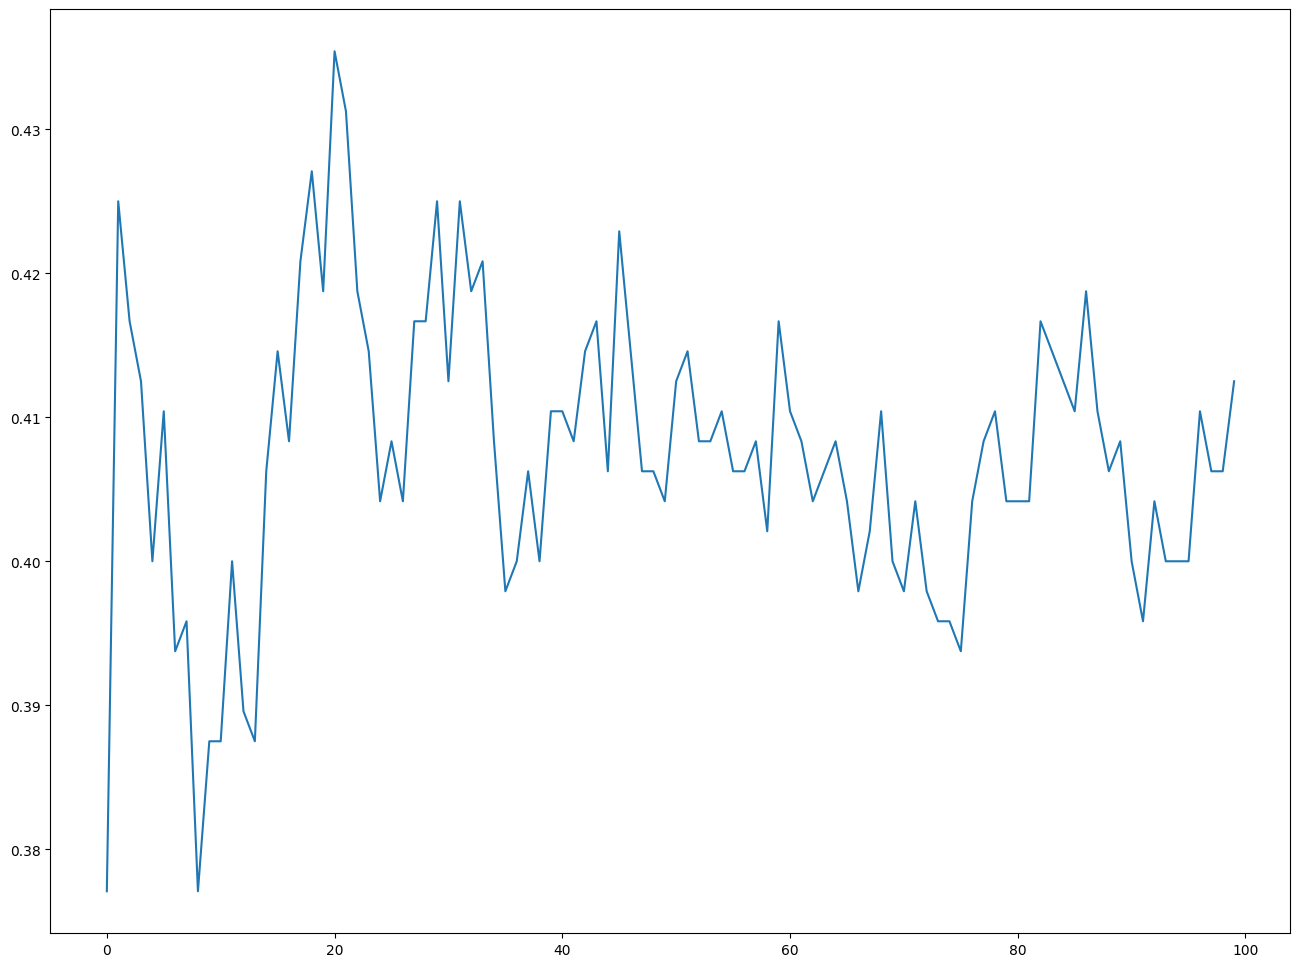

In [14]:
#Example 2.2 for KNN classification
#https://www.freecodecamp.org/news/how-to-build-and-train-k-nearest-neighbors-ml-models-in-python/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%matplotlib inline

#Import the data set
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/week11/winequality-red.csv', delimiter = ";")
# print(data.head())
# print("\n")

#Import standardization functions from scikit-learn
#Standardize the data set
scaler = StandardScaler()
scaler.fit(data.drop('quality', axis=1))
scaled_features = scaler.transform(data.drop('quality', axis=1))
scaled_data = pd.DataFrame(scaled_features, columns = data.drop('quality', axis=1).columns)

#Split the data set into training data and test data
X= scaled_data
y = data['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#Train the model and make predictions
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Performance measurement
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("\n")

#Selecting an optimal K value
error_rates = []

for i in np.arange(1, 101): # iterates over a range of 1 to 100 (inclusive of 1 but excluding 101)
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(X_train, y_train)
    new_predictions = new_model.predict(X_test)
    error_rates.append(np.mean(new_predictions != y_test))

plt.figure(figsize=(16,12))
plt.plot(error_rates)


In [17]:
#Example 3.3 for digit classification
#https://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html#sphx-glr-auto-examples-exercises-plot-digits-classification-exercise-py
from sklearn import datasets, neighbors, linear_model
from sklearn.datasets import load_digits

X_digits, y_digits = datasets.load_digits(return_X_y=True)
X_digits = X_digits / X_digits.max() #divide each element by the maximum value present in the array.

n_samples = len(X_digits) # returns the number of elements (rows)

X_train = X_digits[:int(.9 * n_samples)] #90% of the samples will be included in the training set
y_train = y_digits[:int(.9 * n_samples)]
X_test = X_digits[int(.9 * n_samples):] # remainder of the samples will be included in the testing set
y_test = y_digits[int(.9 * n_samples):]

knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression(max_iter=1000)

print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))
print('LogisticRegression score: %f'
      % logistic.fit(X_train, y_train).score(X_test, y_test))
print("\n")


KNN score: 0.961111
LogisticRegression score: 0.933333




In [ ]:
#Example 3.4 Plot of KN Classifiers
#https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# load dataset
iris = datasets.load_iris()

# we only take the first two features
# slicing by using a two-dim dataset
X = iris.data[:, :2] #all rows in the array, columns starting from the beginning up to, but not including, the 2nd index
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()
